<a href="https://colab.research.google.com/github/pietroventurini/predict-future-sales/blob/grid-v1/Predict_Future_Sales_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle competition: Predict Future Sales

TODO
- trattare diversamente items nel test set di cui si ha informazione nel train set da quelli che non compaiono nel train set.
- predictions: prima uso _previous value benchmark_ in cui uso vendite del mese di ottobre come proxy di quelle di novembre, poi, senza fare feature engineering provo ad usare un DT model
- provare a effettuare clip(0,20) solo alla fine
- non mi piace l'approccio di anqitu perché accoppia shop-item se anche uno solo dei due elementi compare in un certo mese... provare piuttusto ad accoppiare shop-elementi solo se tale coppia compare in un certo mese
- provare `shuffle=True` con mean encoding
- capire perché expanding mean è quello con corr maggiore e KFold minore (provare a tenere il minore invece che il maggiore)

[Questo notebook](https://www.kaggle.com/anqitu/feature-engineer-and-model-ensemble-top-10/code) usa date di novembre 2014 come proxy per Nov 2015.

In the [**predict future sales**](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) competition we are working with a time-series dataset consisting of daily sales data. The goal is to predict total sales for every product and store in the next month.

We are going to approach the problem in this way:
1. **Exploratory data analysis:** take a look at the dataset and perform data cleaning.
2. **Feature engineering:** understand which useful information can be extracted from the features.
3. **Modelling:** choose a suitable model for the problem.
4. **Training:** train the model on the training set
5. **Tweaking the model:** tweak the model parameters in order to improve the performances.
6. **Model evaluation:** try to predict future sales and evaluate the performances of the model.

# Exploratory Data Analysis



Let's start by exploring the content of our dataset. According to the competition description, the training data is provided in 4 different .csv files:

- `sales_train.csv` - the training set. Daily historical data from January 2013 to October 2015.
- `items.csv` - supplemental information about the items/products.
- `item_categories.csv`  - supplemental information about the items categories.
- `shops.csv`- supplemental information about the shops.

Sales and shops are represented by the following fields:

- `ID` - an Id that represents a (Shop, Item) tuple within the test set
- `shop_id` - unique identifier of a shop
- `item_id` - unique identifier of a product
- `item_category_id` - unique identifier of item category
- `item_cnt_day` - number of products sold. You are predicting a monthly amount of this measure
- `item_price` - current price of an item
- `date` - date in format dd/mm/yyyy
- `date_block_num` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- `item_name` - name of item
- `shop_name` - name of shop
- `item_category_name` - name of item category

The content of the datasets is in russian, so we may think of translating it into english because many interesting features can be extracted from the names of the products, shops and categories, for instance:
- Books - Audio Books
- Books - Computer books
- Books - …

From those names we could build a feature that contains only the top level category. The translation can be done manually using some python libraries (e.g. googletrans), but other competitors have already taken the trouble to translate it for us. Translated datasets can be recognized by the `_en` suffix. However, translation can break the structure of some names (e.g. russian shop names comes in the format `city | type | name`, so by translating them in english we risk to break that structure) and complicate our life when extracting features from them.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import time
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

# Constants
RND_SEED = 11
Validation = False

### Loading data

In [2]:
train = pd.read_csv('./datasets/sales_train.csv')
items = pd.read_csv('./datasets/items.csv')
categories = pd.read_csv('./datasets/item_categories.csv')
shops = pd.read_csv('./datasets/shops.csv')
test = pd.read_csv('./datasets/test.csv')

train.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
print("\n-----------Information-----------")
print(train.info())
print("\n----------Null values-----------")
print(train.isnull().sum())
print("\n----------Shape of Data----------")
print(train.shape)


-----------Information-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None

----------Null values-----------
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

----------Shape of Data----------
(2935849, 6)


### Downcasting

As we can see from the information block, the training set is 134.4+ MB in size, so, in order to reduce the memory occupation, we can downcast the dataframe from _int64_ and _float64_ to _int16_ and _float32_.

In [4]:
def downcast(df): 
    float_cols = [c for c in df if df[c].dtype == 'float64']
    int_cols = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

train = downcast(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int16  
 2   shop_id         int16  
 3   item_id         int16  
 4   item_price      float32
 5   item_cnt_day    float32
dtypes: float32(2), int16(3), object(1)
memory usage: 61.6+ MB


We have reduced the size of the training set from 134.4 MB down to 61.6+ MB.

## Data cleaning

In [5]:
# remove duplicated rows
train = train.drop_duplicates()

# view information about prices and sold quantities
train[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935843e+06,2.935843e+06
mean,8.906237e+02,1.242641e+00
std,1.726442e+03,2.612216e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


The first thing that catches the eye is the fact that the minimum price and the minimum sold quantity are negative, respectively, the minimum price is -1 and the minimum sold quantity is -22. 

### Negative prices

In [6]:
# items with price <= 0
neg_items = train[train.item_price <= 0]
neg_items

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [7]:
# get details of the item with price < 0
neg_item = neg_items.iloc[0]
items.loc[items['item_id'] == neg_item['item_id']]

,item_name,item_id,item_category_id
2973,"DmC Devil May Cry [PS3, русские субтитры]",2973,19


Fortunately, there is only one item with a negative price. We could replace it with the median of the prices, but let's try to be more precise. The item in question is a PS3 game. Typically, game prices decreases over time from their release date, and tend to be the same among different sellers. Therefore, let's see if other shops sold the same item in that date (extending the search to the same week or month, if necessary), and use that price as a proxy for our missing value. Otherwise, we could average the price for that item from the same shop in the next few days.

In [8]:
train[(train['item_id'] == neg_item['item_id']) & (train['date'] == neg_item['date'])]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,15.05.2013,4,25,2973,1249.5,1.0
469026,15.05.2013,4,46,2973,1249.5,1.0
469951,15.05.2013,4,45,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,-1.0,1.0


In [9]:
# set the product price to that value
train.loc[train.item_price <= 0, 'item_price'] = 1249.0

### Negative quantities sold

Let's now deal with negative quantities sold. By looking at some of the discussions on the competition page, I've seen that many people considered negative values for `item_cnt_day` as returned items. Let's stick to that interpretation and set them equal to zero.

In [10]:
train.loc[train.item_cnt_day < 0, 'item_cnt_day'] = 0

### Outliers

Let's take a look at the distributions of prices and quantities.

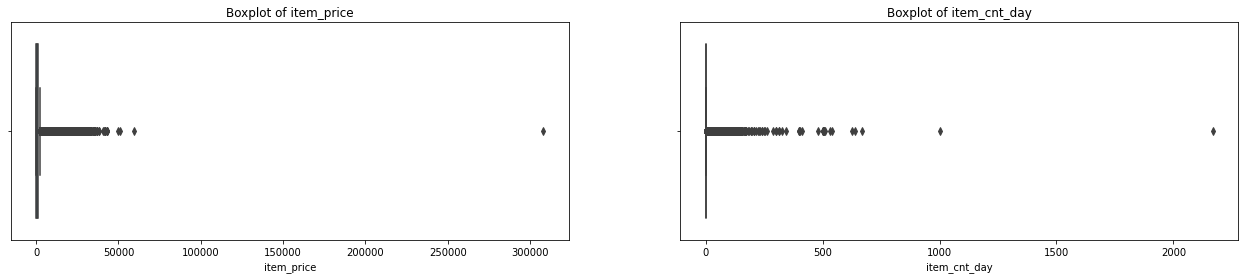

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(22,4))
sns.boxplot(x='item_price', data=train, ax=axs[0])
sns.boxplot(x='item_cnt_day', data=train, ax=axs[1])
axs[0].set_title('Boxplot of item_price')
axs[1].set_title('Boxplot of item_cnt_day')
plt.show()

First of all, there is an item with a very large price that we should inspect. Similarly there are few items with a large number of units sold in a single day.

In [12]:
# most expensive item
train.loc[train.item_price.idxmax()]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price            307980
item_cnt_day               1
Name: 1163158, dtype: object

In [13]:
# most sold item in a day
train.loc[train.item_cnt_day.idxmax()]

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day            2169
Name: 2909818, dtype: object

In [14]:
fig = px.scatter(train.loc[train.item_id == 11373], x='date', y='item_cnt_day', title="Quantities of item #11373 (Boxberry delivery) sold every day")
fig.show()

I decided to remove those outliers since
1. The item with cost 6066 (which is a product called _"Radmin 3"_) has been sold exactly one time on that day only.
2. The item sold 2169 times in a single day (that i suspect to be a service rather than a product, because of its name _"Delivery to the delivery point (Boxberry)"_) is sold in much smaller quantities in every other date.

### Duplicated shops

As other participants pointed out, some shops have the same name. The shops list is short enough to be inspected manually so we can find them. If it were longer, we could have applied some fuzzy string matching algorithm on the shops names (e.g. we could have measured similarity between names using the Levenshtein distance) in order to detect similar names. Since there was no further information about the shops other than their name, and since in the test set they appear with only one of the two IDs, I decided to merge together those with the same name, using the IDs in the test set.
- 0 ⇒ 57
- 1 ⇒ 58
- 11 ⇒ 10
- 40 ⇒ 39

In [15]:
train = train[train.item_price < 100000]
train = train[train.item_cnt_day < 1500]

In [16]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 11, 'shop_id'] = 10
train.loc[train.shop_id == 40, 'shop_id'] = 39

# keep only shops that are present either in the train set or in the test set
shops = shops.loc[shops.shop_id.isin(train.shop_id) | shops.shop_id.isin(test.shop_id)]

In [17]:
print('Shops only in the train set:', set(shops.shop_id) - set(test.shop_id))
print('Shops only in the test set:', set(shops.shop_id) - set(train.shop_id))

Shops only in the train set: {32, 33, 8, 9, 43, 13, 17, 51, 20, 54, 23, 27, 29, 30}
Shops only in the test set: set()


In [18]:
## Rimuovere o spostare

#sales_by_item = train.pivot_table(values='item_cnt_day', index=['item_id'], columns=['date_block_num'], aggfunc=np.sum, fill_value=0).reset_index()
#sales_by_item.columns = sales_by_item.columns.map(str)
#sales_by_item = sales_by_item.rename_axis(None, axis=1)
#sales_by_item

# Feature engineering

In this section we will try to create features that may help the model to make more accurate predictions about future sales. Remember that we are requested to predict sales for product-store pairs.

## Shops

Let's start by dealing with shops. Each shops is simply described by `shop_name`. By looking at their names, it looks like that every name has the structure `Shop City | Shop Type | Shop Name` (this was pointed out by other competitors who understand russian language). Thanks to this, we can extract those information into separate features.

In [19]:
# remove non alphanumeric characters and numbers
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()

# get city names (first word) 
shops['shop_city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])

# get shop types
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x 
                         else 'трц' if 'трц' in x 
                         else 'трк' if 'трк' in x 
                         else 'тц' if 'тц' in x 
                         else 'тк' if 'тк' in x 
                         else np.nan)

In [20]:
# add first month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].min()).rename(columns={'date_block_num':'shop_first_month'})

# add last month to each shop
shops = shops.join(train.groupby('shop_id')['date_block_num'].max()).rename(columns={'date_block_num':'shop_last_month'})

# label encoding names
shops = shops.fillna('NO_DATA')
cols_to_encode = ['shop_name','shop_city','shop_type']
encoded_cols = [col+'_enc' for col in cols_to_encode]
shops[encoded_cols] = shops[cols_to_encode].apply(LabelEncoder().fit_transform)
#shops = shops.join(pd.get_dummies(shops[cols_to_encode]).add_suffix('_enc'))

shops = shops.drop(columns=cols_to_encode)
shops = downcast(shops)
shops.head(5)

# note: if you want to replace directly the columns with their encoded version, just override them
# in that case, to later perform inverse_transform see https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

,shop_id,shop_first_month,shop_last_month,shop_name_enc,shop_city_enc,shop_type_enc
2,2,0,33,0,0,5
3,3,0,33,1,1,3
4,4,0,33,2,2,5
5,5,1,33,3,3,4
6,6,0,33,4,4,0


For every shop in the test set we have data up to the last month in the training set (`date_block_num = 33`). There are some shops that do not pop up in the test set, anyway, they can still be useful to predict certain product sales for other shops.

In [21]:
print("Shops that are not in the test set: ", shops.loc[~shops.shop_id.isin(test.shop_id), 'shop_id'].to_list())
# uncomment next line to see details about those shops
# shops[~shops.shop_id.isin(test.shop_id)]

Shops that are not in the test set:  [8, 9, 13, 17, 20, 23, 27, 29, 30, 32, 33, 43, 51, 54]


## Item categories


Categories are described by a name which can have either the form `type - subtype` (e.g. `Книги - Путеводители` which means `books - travel guides`) or a single name (e.g. `Доставка товара` which means `delivery of goods`). Let's split composite category names into:
- section
- main category name
- main sub-category name
- secondary sub-category name

Here we have to get our hands dirty and deal with each category in detail because not every name has that structure.

Note: I decided to translate sections into english for visualization purposes, but note that it was not necessary since later we will perform label encodings.

In [22]:
# before
categories[:10]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [23]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['section'] = categories['split'].map(lambda x: x[0].strip())
categories['name'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0])
categories = categories[['item_category_id', 'section', 'name']]

# games
categories.loc[26:31, 'sub_name'] = categories.loc[26:32, 'name']
categories.loc[26:31, 'name'] = categories.loc[26:32, 'section'].str.split(' ').map(lambda x: x[1])
categories.loc[18:31, 'section'] = 'games'

# PlayStation stuff
is_ps = categories.name.str.contains('PS')
categories.loc[is_ps, 'sec_sub_name'] = categories.loc[is_ps, 'name'].map(lambda x: x.split('PS')[1])
categories.loc[is_ps, 'sub_name'] = 'PS'

# XBOX stuff
is_xbox = categories.name.str.contains('XBOX')
categories.loc[is_xbox, 'sec_sub_name'] = categories.loc[is_xbox, 'name'].map(lambda x: x.split('XBOX')[1])
categories.loc[is_xbox, 'sub_name'] = 'XBOX'

# split name - subname
categories.loc[45, 'sec_sub_name'] = '1C'
categories.loc[43:45, 'sub_name'] = 'audiobooks'
categories.loc[55, 'sec_sub_name'] = 'локального'
categories.loc[56, 'sec_sub_name'] = 'фирменного'
categories.loc[55:56, 'sub_name'] = 'CD'
categories.loc[81:82, 'sub_name'] = categories.name.loc[81:82].map(lambda x: x[x.find('(')+1:x.find(')')])

# extract subname within brackets e.g. {name: "Live! (Цифра)"} --> {sub_name: "Live!", sec_sub_name: "Цифра"}
has_subname = categories.name.str.contains('\(.*?\)')
categories.loc[has_subname, 'sec_sub_name'] = categories.loc[has_subname, 'name'].map(lambda x: x[x.find('(')+1:x.find(')')])
categories.loc[has_subname, 'sub_name'] = categories.loc[has_subname, 'name'].str.split('(').map(lambda x: x[0])

# rename sections
categories.loc[1:7, 'section'] = 'accessories'
categories.loc[8, 'section'] = 'tickets'
categories.loc[9, 'section'] = 'delivery of goods'
categories.loc[10:17, 'section'] = 'consoles'
categories.loc[32:36, 'section'] = 'cards'
categories.loc[37:41, 'section'] = 'movies'
categories.loc[42:54, 'section'] = 'books'
categories.loc[55:60, 'section'] = 'music'
categories.loc[61:72, 'section'] = 'gifts'
categories.loc[73:78, 'section'] = 'software'
categories.loc[81:82, 'section'] = 'disks'
categories.loc[83, 'section'] = 'batteries'

In [24]:
# after
categories[:10]

,item_category_id,section,name,sub_name,sec_sub_name
0,0,PC,Гарнитуры/Наушники,NaN,NaN
1,1,accessories,PS2,PS,2
2,2,accessories,PS3,PS,3
3,3,accessories,PS4,PS,4
4,4,accessories,PSP,PS,P
5,5,accessories,PSVita,PS,Vita
6,6,accessories,XBOX 360,XBOX,360
7,7,accessories,XBOX ONE,XBOX,ONE
8,8,tickets,Билеты (Цифра),Билеты,Цифра
9,9,delivery of goods,Доставка товара,NaN,NaN


In [25]:
# label encoding names
categories = categories.fillna('NO_DATA')
cols_to_encode = ['section','name','sub_name','sec_sub_name']
encoded_cols = ['section_enc','name_enc','sub_name_enc','sec_sub_name_enc']
categories[encoded_cols] = categories[cols_to_encode].apply(LabelEncoder().fit_transform)
#categories = categories.join(pd.get_dummies(categories[['section','name','sub_name','sec_sub_name']]).add_suffix('_enc'))

categories = categories.drop(columns=cols_to_encode)
categories = downcast(categories)
categories

# note: if you want to replace directly the columns with their encoded version, just override them
# in that case, to later perform inverse_transform see https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

,item_category_id,section_enc,name_enc,sub_name_enc,sec_sub_name_enc
0,0,0,32,3,7
1,1,1,12,4,3
2,2,1,13,4,4
3,3,1,14,4,5
4,4,1,16,4,8
...,...,...,...,...,...
79,79,14,55,3,7
80,80,14,28,3,7
81,81,7,62,19,16
82,82,7,63,19,17


## Item sales

- daily revenue
- monthly revenue
- lagged features
- mean encoded features ✅
- Release date
- Last month sale
- Days on sale
- Neighbors (items with id 1000 and 1001 could be somehow similar - genre, type, release date)

As we've seen so far, there are periods in which no data is available for a certain shop or for a certain item (maybe because it is not available in a certain store), so, what should we do for those cases? Extending the dataset by inlcuding every possible combination of day-shop-item would make the training set reaching over 1B entries.

In [26]:
print("Power set (date ⨯ shop ⨯ item) size is", len(train.date.unique()) * len(train.shop_id.unique()) * len(train.item_id.unique()))

Power set (date ⨯ shop ⨯ item) size is 1262654624


If we considered only `date_block_num` instead of `date`, we would end up with ~41M entries, but we would lose information about daily sales, which, intuitively, can turn useful when predicting sales for November 2015.

In [27]:
print("Power set (date_block_num ⨯ shop ⨯ item) size is", len(train.date_block_num.unique()) * len(train.shop_id.unique()) * len(train.item_id.unique()))

Power set (date_block_num ⨯ shop ⨯ item) size is 41518624


### [Anqitu's approach](https://www.kaggle.com/anqitu/feature-engineer-and-model-ensemble-top-10/code)

In the next script we will consider only the shops that are present both in the training and in the test set. Then, we construct a grid of triplets (`date_block_num`, `shop_id`, `item_id) grouping together, for each month, all the shops and all the items for which we have a record in the training set.

In [28]:
# keep in train only sales associated to shops that are also in the test set
train = train.merge(test[['shop_id']].drop_duplicates(), how='inner')

from itertools import product

# create grid of (date_block_num, shop_id, item_id) triplets from train set
grid = []

for block_num in train['date_block_num'].unique():
  mthly_shops = train[train.date_block_num == block_num]['shop_id'].unique()
  mthly_items = train[train.date_block_num == block_num]['item_id'].unique()
  grid.append(np.array(list(product(*[mthly_shops, mthly_items, [block_num]])), dtype='int32'))

sales = pd.DataFrame(np.vstack(grid), columns=['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)

# clip target values in [0-20]
train['item_cnt_day'] = train['item_cnt_day'].clip(0,20)

# get monthly sales for each (shop, item) pair in train set
mthly_sales = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})
mthly_sales['item_cnt_month'] = mthly_sales['item_cnt_month'].clip(0,20).astype(int)
sales = pd.merge(sales, mthly_sales, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0)
sales['item_cnt_month'] = sales['item_cnt_month'].astype(int)

# get monthly average price for each (shop, item) pair in train set
avg_prices = train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index().rename(columns={'item_price': 'item_avg_price'})
sales = pd.merge(sales, avg_prices, how='left', on=['shop_id', 'item_id', 'date_block_num']).fillna(0)

sales = downcast(sales)
sales = sales.sort_values(['date_block_num', 'shop_id', 'item_id'])

In [29]:
# merge train with items
sales = sales.merge(items[['item_id', 'item_category_id']], on=['item_id'], how='left')

# merge test with items
test = test.merge(items[['item_id', 'item_category_id']], on=['item_id'], how='left')

# merge train with categories
sales = sales.merge(categories, on=['item_category_id'], how='left')

# merge test with categories
test = test.merge(categories, on=['item_category_id'], how='left')

# merge train with shops
sales = sales.merge(shops, on=['shop_id'], how='left')

# merge test with shops
test = test.merge(shops, on=['shop_id'], how='left')

del grid, mthly_sales, mthly_shops, mthly_items, categories, shops
gc.collect()

15247

## Dates

Possible dates features may be: 
- Weekends and holidays sales (to correct monthly sales)
- Number of days in the month (to correct monthly sales)
- Month number (for seasonal items)

Note that, in our training set, for every date between `2013-01-01` and `2015-10-31`, there exist at least one sale. Recall that the variable `date_block_num` varies over the range 0-33, where 0 corresponds to January 2013 and 33 to October 2015, and we are requested to predict sales for November 2015.

In [30]:
# create dates from sdate (Jan 1, 2013) to edate (Nov 30, 2015)
sdate = pd.to_datetime('2013-01-01')
edate = pd.to_datetime('2015-11-30')
dates = pd.date_range(sdate, edate, freq='d').to_frame(index=False, name='date')

# add features
dates['year'] = dates['date'].dt.year
dates['month'] = dates['date'].dt.month
dates['date_block_num'] = (dates['year']-2013) * 12 + dates['month'] - 1
dates['weekday'] = dates['date'].dt.weekday
dates['is_weekend'] = dates['date'].dt.day_name().map(lambda x: x in ['Saturday', 'Sunday'])

# dummies: 0: Monday ... 6: Sunday
dates = pd.get_dummies(dates, columns=['weekday']) 
weekdays = ['weekday_{}'.format(i) for i in range(6+1)]

# count days in each month
monthly_data = dates.groupby(['year','month','date_block_num'])[weekdays].agg('sum').reset_index()
monthly_data['month_length'] = monthly_data[weekdays].sum(axis=1)

# count number of weekend (saturdays and sundays) in each month
monthly_data['weekend_days'] = dates.groupby(['date_block_num'])[['is_weekend']].agg('sum')

# encode year (0: 2013, 1: 2014, 2: 2015)
monthly_data['year'] = monthly_data['year'] - 2013

# # count days in each month
# months_length = pd.DataFrame(dates.groupby(['date_block_num'])[weekdays].agg('sum').sum(axis=1), columns=['month_length']) 
# dates = dates.join(months_length, on='date_block_num')

# # count number of weekend (saturdays and sundays) in each month
# weekend_days = dates.groupby(['date_block_num'])[['is_weekend']].agg('sum').rename(columns={'is_weekend':'weekend_days'})
# dates = dates.join(weekend_days, on='date_block_num')

# # encode year (0: 2013, 1: 2014, 2: 2015)
# dates['year'] = dates['year'] - 2013


# merge sales and test with monthly data
sales = sales.merge(monthly_data[['year','month','date_block_num','month_length','weekend_days']], on='date_block_num', how='left')
sales = downcast(sales)

test['date_block_num'] = 34
test = test.merge(monthly_data[['year','month','date_block_num','month_length','weekend_days']], on='date_block_num', how='left')
test = downcast(test)

In [31]:
del train, dates, monthly_data, weekdays, sdate, edate
gc.collect()

50

In [32]:
sales.head(5)

,shop_id,item_id,date_block_num,item_cnt_month,item_avg_price,item_category_id,section_enc,name_enc,sub_name_enc,sec_sub_name_enc,shop_first_month,shop_last_month,shop_name_enc,shop_city_enc,shop_type_enc,year,month,month_length,weekend_days
0,2,19,0,0,0.0,40,10,5,3,7,0,33,0,0,5,0,1,31,8
1,2,27,0,1,2499.0,19,8,13,4,4,0,33,0,0,5,0,1,31,8
2,2,28,0,0,0.0,30,8,11,16,7,0,33,0,0,5,0,1,31,8
3,2,29,0,0,0.0,23,8,19,6,0,0,33,0,0,5,0,1,31,8
4,2,32,0,0,0.0,40,10,5,3,7,0,33,0,0,5,0,1,31,8


## Mean encodings

We will now compute mean encodings for categorical columns using different approaches in order to cope with overfitting:
- K-Fold
- Leave-One-Out
- Smoothing
- Expanding mean

For each column, we are selecting the encoding with the largest value of the Pearson correlation coefficient with respect to the true target values.

In [33]:
target = 'item_cnt_month'
global_mean = sales[target].mean()
y_sales = sales[target].values

mean_encoded_cols = ['shop_id', 'item_id', 'item_category_id'] + [x for x in sales.columns if x.endswith('_enc')]

for col in mean_encoded_cols:
    col_tr = sales[[col] + [target]].copy()
    corrcoef = pd.DataFrame(columns=['Cor']) # will contain correlation coefficients of each encoding scheme for the current column

    # Mean encodings - KFold
    col_tr[col+'_mean_Kfold'] = global_mean
    kf = KFold(n_splits=5, shuffle=False)
      
    # for tr_idx, val_idx in kf.split(col_tr):
    #     X_tr, X_val = col_tr.iloc[tr_idx].copy(), col_tr.iloc[val_idx].copy()
    #     X_val[col+'_mean_Kfold'] = X_val[col].map(X_tr.groupby(col)[target].mean())
    #     col_tr.iloc[val_idx] = X_val
    
    # one-liner to avoid copy()
    for tr_idx, val_idx in kf.split(col_tr):
        col_tr.loc[val_idx, col+'_mean_Kfold'] = col_tr.loc[val_idx, col].map(col_tr.iloc[tr_idx].groupby(col)[target].mean())
    
    col_tr[col+'_mean_Kfold'].fillna(global_mean, inplace=True)
    corrcoef.loc[col+'_mean_Kfold'] = np.corrcoef(y_sales, col_tr[col+'_mean_Kfold'])[0][1] # np.corrcoef returns a 2⨉2 matrix 
    
    # Mean encodings - Leave One Out
    col_tr[col+'_cnt_month_sum'] = col_tr[col].map(col_tr.groupby(col)[target].sum())
    col_tr[col+'_cnt_month_count'] = col_tr[col].map(col_tr.groupby(col)[target].count())
    col_tr[col+'_mean_LOO'] = (col_tr[col+'_cnt_month_sum'] - col_tr[target]) / (col_tr[col+'_cnt_month_count'] - 1)
    col_tr[col+'_mean_LOO'].fillna(global_mean, inplace=True)
    corrcoef.loc[col+'_mean_LOO'] = np.corrcoef(y_sales, col_tr[col+'_mean_LOO'])[0][1]

    # Mean encodings - Smoothing
    alpha = 100
    col_tr[col+'_mean'] = col_tr[col].map(col_tr.groupby(col)[target].mean())
    col_tr[col+'_mean_smooth'] = (col_tr[col+'_mean']*col_tr[col+'_cnt_month_count'] + global_mean*alpha) / (col_tr[col+'_cnt_month_count'] + alpha)
    col_tr[col+'_mean_smooth'].fillna(global_mean, inplace=True)
    corrcoef.loc[col+'_mean_smooth'] = np.corrcoef(y_sales, col_tr[col+'_mean_smooth'])[0][1]

    # Mean encodings - Expanding Mean
    cumsum = col_tr.groupby(col)[target].cumsum() - col_tr[target]
    sumcnt = col_tr.groupby(col).cumcount()
    col_tr[col+'_mean_expanding'] = cumsum / sumcnt
    col_tr[col+'_mean_expanding'].fillna(global_mean, inplace=True)
    corrcoef.loc[col+'_mean_expanding'] = np.corrcoef(y_sales, col_tr[col+'_mean_expanding'])[0][1]

    # append mean encoded column with highest correlation to the training set
    sales = pd.concat([sales, col_tr[corrcoef['Cor'].idxmax()]], axis=1)

    print(corrcoef.sort_values('Cor', ascending=False))

                             Cor
shop_id_mean_expanding  0.175150
shop_id_mean_smooth     0.175016
shop_id_mean_LOO        0.174991
shop_id_mean_Kfold      0.172836
                             Cor
item_id_mean_expanding  0.565665
item_id_mean_LOO        0.481724
item_id_mean_smooth     0.479641
item_id_mean_Kfold      0.312957
                                      Cor
item_category_id_mean_expanding  0.292890
item_category_id_mean_LOO        0.289988
item_category_id_mean_smooth     0.289958
item_category_id_mean_Kfold      0.270138
                                 Cor
section_enc_mean_expanding  0.173299
section_enc_mean_smooth     0.168440
section_enc_mean_LOO        0.168396
section_enc_mean_Kfold      0.155141
                              Cor
name_enc_mean_expanding  0.265414
name_enc_mean_LOO        0.260702
name_enc_mean_smooth     0.260669
name_enc_mean_Kfold      0.238943
                                  Cor
sub_name_enc_mean_expanding  0.201763
sub_name_enc_mean_smooth     

In [34]:
# merge all data in df
if not Validation:
  test['date_block_num'] = 34
  sales = pd.concat([sales, test], axis=0)
  sales = sales.drop(columns=['ID'])
  del test

sales = downcast(sales)

# free memory
del col_tr
gc.collect()

86

## Lag features

We are now going to add lagged features for lags from 1 to 12 months. Those feature could help the model to find interactions between the present and the past (e.g. how much current sales are influenced by last month sales).

In [35]:
def lag_features(df, features=['item_cnt_month'], lags=[1], period_col='date_block_num', groupby=['shop_id', 'item_id'], agg_fun={}, new_name=None):
  """Returns the dataframe provided as input
  expanded with the the lags of the features specified
  """
  for lag in lags:
    df_shifted = df.copy()
    grouping_cols = groupby + [period_col]
    if agg_fun:
      df_shifted = df_shifted.groupby(grouping_cols).agg(agg_fun).reset_index()
    if new_name:
      new_names = lambda x: '{}_lag_{}'.format(new_name, lag) if x in features else x
    else:
      new_names = lambda x: '{}_lag_{}'.format(x, lag) if x in features else x
    df_shifted[period_col] += lag
    df_shifted = df_shifted.rename(columns = new_names)
    cols_to_merge = grouping_cols + [col for col in df_shifted.columns if col.endswith('lag_{}'.format(lag))]
    df = df.merge(df_shifted[cols_to_merge], on=grouping_cols, how='left').fillna(0)
  return df  

In [36]:
#lags = [x for x in range(1,12+1)]
lags = [1,2,12]

# delay monthly sales for each (shop,item) pair
sales = lag_features(sales, lags=lags, groupby=['shop_id','item_id'])

# delay monthly sales for each item independently of shops
sales = lag_features(sales, lags=lags, groupby=['item_id'], agg_fun={'item_cnt_month':'mean'}, new_name='item_avg_cnt_month')

# delay monthly average prices for each (shop,item) pair
sales = lag_features(sales, features=['item_avg_price'], lags=lags, groupby=['shop_id','item_id'], agg_fun={'item_avg_price':'mean'}, new_name='item_shop_avg_price')

In [37]:
sales.dtypes

shop_id                              int16
item_id                              int16
date_block_num                       int16
item_cnt_month                     float32
item_avg_price                     float32
item_category_id                     int16
section_enc                          int16
name_enc                             int16
sub_name_enc                         int16
sec_sub_name_enc                     int16
shop_first_month                     int16
shop_last_month                      int16
shop_name_enc                        int16
shop_city_enc                        int16
shop_type_enc                        int16
year                                 int16
month                                int16
month_length                         int16
weekend_days                         int16
shop_id_mean_expanding             float32
item_id_mean_expanding             float32
item_category_id_mean_expanding    float32
section_enc_mean_expanding         float32
name_enc_me

## Scaling

# Model